<a href="https://colab.research.google.com/github/LIYunzhe1408/Facial-Keypoint-Detection/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [ ]:
# Fetch data
!mkdir data
!wget -P data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n data/train-test-data.zip -d data

mkdir: cannot create directory ‘data’: File exists
--2025-04-14 06:23:41--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 3.5.30.15, 3.5.8.238, 54.231.131.80, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|3.5.30.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘data/train-test-data.zip.3’

train-test-data.zip 100%[===================>] 322.93M  49.1MB/s    in 6.8s    

2025-04-14 06:23:49 (47.3 MB/s) - ‘data/train-test-data.zip.3’ saved [338613624/338613624]

Archive:  data/train-test-data.zip


# Setup Environment

In [ ]:
# No need if you are using colab

# !pip install matplotlib~=3.5.2
# !pip install scikit-image==0.19.2
# !pip install torch~=1.8.1
# !pip install torchvision~=0.9.1
# !pip install numpy~=1.21.6
# !pip install pillow~=9.1.1
# !pip install tqdm~=4.64.0
# !pip install jupyter==1.0.0
# !pip install opencv-python==4.6.0.66
# !pip install pandas==1.3.5


# Visualize the data

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


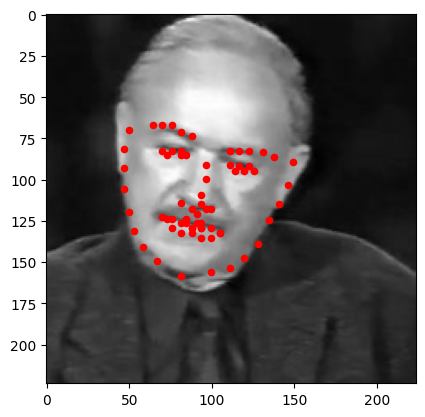

In [ ]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
)
# load training data in batches
batch_size = 32
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform
)
# loading test data in batches
batch_size = 32
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image black and white
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    plt.show()
    break


## Part1-SimpleNet
Find best hyperparameters
* Loss Function
* Learning Rate
* Optimizer
* Dropout Layer weights

In [ ]:
from models import SimpleNet
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}.pth"
        best_val_loss = float("inf")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# ===================================
# Part 1 Net
# Loss Function
# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()

# net_batch_64 = SimpleNet()
# net_LR_05 = SimpleNet()
# net_LR_00005 = SimpleNet()

# net_AdamW = SimpleNet()
net_dropout_all_02 = SimpleNet()


# ========== HYPERPARAMETERS ==========
n_epochs = 10
# optimizer_smoothL1 = optim.Adam(net_LR_00005.parameters(), lr=0.0005)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)
optimizer = optim.AdamW(net_dropout_all_02.parameters(), lr=0.0005)


# ========== TRAIN MODELS ==========
# Loss Function
# SmoothL1_losses, val_SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)
# MSE_losses, val_MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE, test_loader)

# Batch Size
# LR_05_L1_loss, LR_05_L1_val_loss = train_net(net_LR_00005, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)

# AdamW_loss, AdamW_val_loss = train_net(net_AdamW, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

droupout_all_02_loss, droupout_all_02_val_loss = train_net(net_dropout_all_02, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)


### Evaluation-Viz

#### Loss function

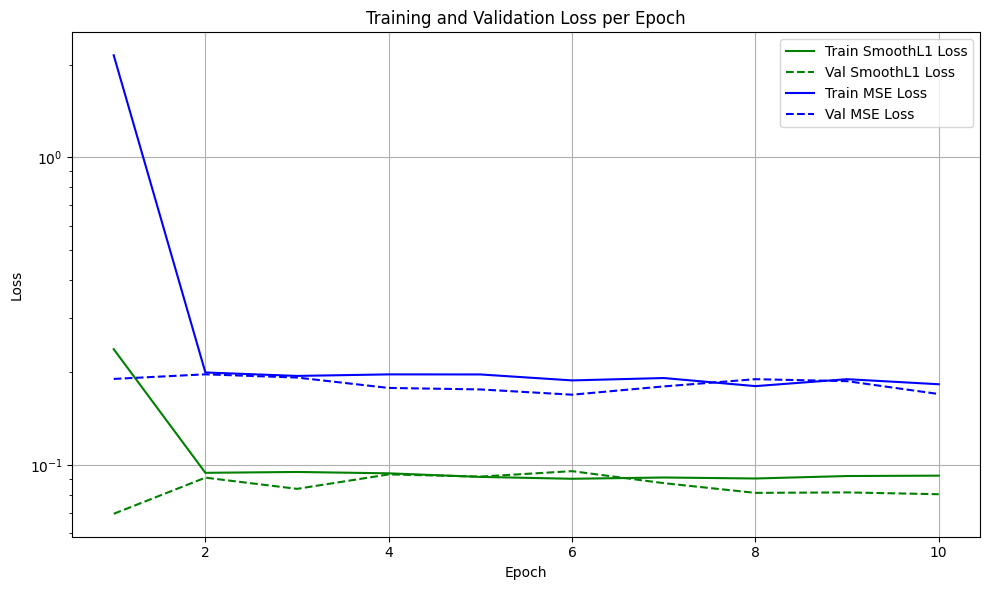

Final training loss: 0.09242875540443223, 0.18315610224338172
Final val loss: 0.08044344028357801, 0.17023054251865466
Best val loss (SmoothL1): 0.06948532591530011, epoch#: 0
Best val loss (MSE): 0.1693831400147506, epoch#: 5


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(SmoothL1_losses) + 1)

# plt.figure(figsize=(10, 6))

# # SmoothL1 loss curves
# plt.plot(epochs, SmoothL1_losses, label='Train SmoothL1 Loss', color='green', linestyle='-')
# plt.plot(epochs, val_SmoothL1_losses, label='Val SmoothL1 Loss', color='green', linestyle='--')

# # MSE loss curves
# plt.plot(epochs, MSE_losses, label='Train MSE Loss', color='blue', linestyle='-')
# plt.plot(epochs, val_MSE_losses, label='Val MSE Loss', color='blue', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {SmoothL1_losses[-1]}, {MSE_losses[-1]}')
# print(f'Final val loss: {val_SmoothL1_losses[-1]}, {val_MSE_losses[-1]}')

# best_val_loss = min(val_SmoothL1_losses)
# best_epoch = val_SmoothL1_losses.index(best_val_loss)
# print(f'Best val loss (SmoothL1): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(val_MSE_losses)
# best_epoch = val_MSE_losses.index(best_val_loss)
# print(f'Best val loss (MSE): {best_val_loss}, epoch#: {best_epoch}')


#### Batch Size

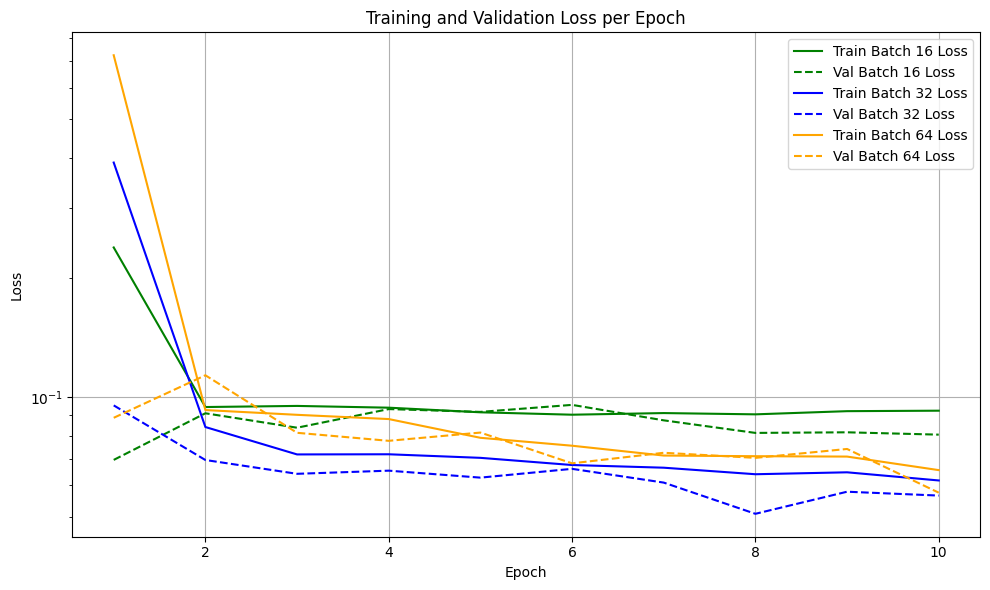

Final training loss: 0.09242875540443223, 0.06167978404789199, 0.06548963366943926
Final val loss: 0.08044344028357801, 0.056507733884966695, 0.05746516709373932
Best val loss (Batch 16): 0.06948532591530011, epoch#: 0
Best val loss (Batch 32): 0.05084166460482429, epoch#: 7
Best val loss (Batch 64): 0.05746516709373932, epoch#: 9


In [ ]:
# batch_16_L1_loss = SmoothL1_losses
# batch_16_L1_val_loss = val_SmoothL1_losses
# batch_16_L1_net = net_SmoothL1

# import matplotlib.pyplot as plt

# epochs = range(1, len(batch_16_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, batch_16_L1_loss, label='Train Batch 16 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_16_L1_val_loss, label='Val Batch 16 Loss', color='green', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train Batch 32 Loss', color='blue', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val Batch 32 Loss', color='blue', linestyle='--')

# # 64 loss curves
# plt.plot(epochs, batch_64_L1_loss, label='Train Batch 64 Loss', color='orange', linestyle='-')
# plt.plot(epochs, batch_64_L1_val_loss, label='Val Batch 64 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {batch_16_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {batch_64_L1_loss[-1]}')
# print(f'Final val loss: {batch_16_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {batch_64_L1_val_loss[-1]}')

# best_val_loss = min(batch_16_L1_val_loss)
# best_epoch = batch_16_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 16): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 32): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_64_L1_val_loss)
# best_epoch = batch_64_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Batch 64): {best_val_loss}, epoch#: {best_epoch}')

#### Learning Rate

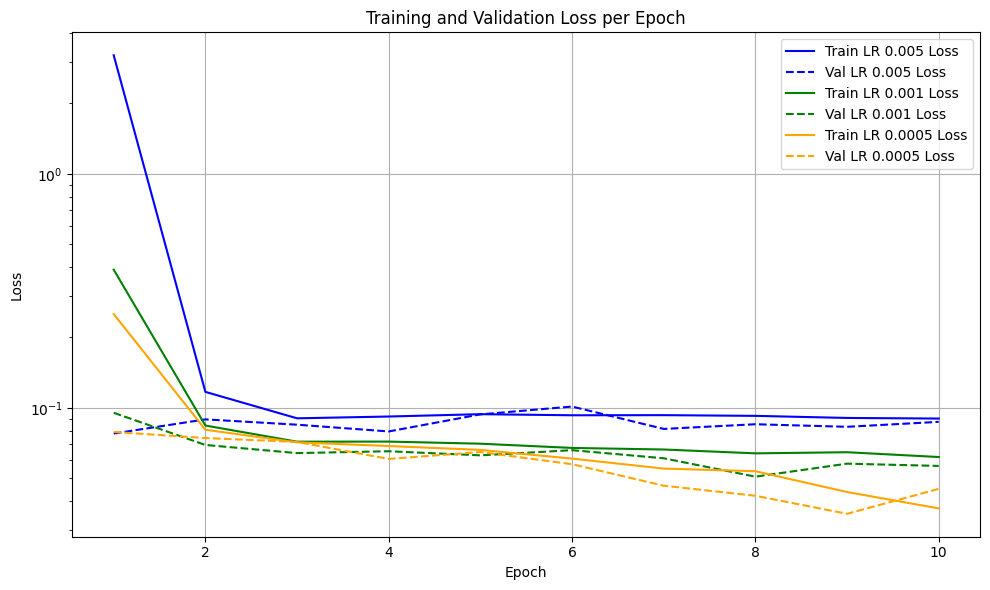

Final training loss: 0.037213279466794265, 0.06167978404789199, 0.09005379214909241
Final val loss: 0.04509976361784689, 0.056507733884966695, 0.08716710537090032
Best val loss (LR 0.005): 0.035286272131784334, epoch#: 8
Best val loss (LR 0.001): 0.05084166460482429, epoch#: 7
Best val loss (LR 0.0005): 0.07772143766586313, epoch#: 0


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, LR_00005_L1_loss, label='Train LR 0.005 Loss', color='blue', linestyle='-')
# plt.plot(epochs, LR_00005_L1_val_loss, label='Val LR 0.005 Loss', color='blue', linestyle='--')

# # 32 loss curves
# plt.plot(epochs, batch_32_L1_loss, label='Train LR 0.001 Loss', color='green', linestyle='-')
# plt.plot(epochs, batch_32_L1_val_loss, label='Val LR 0.001 Loss', color='green', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train LR 0.0005 Loss', color='orange', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val LR 0.0005 Loss', color='orange', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {batch_32_L1_loss[-1]}, {LR_00005_L1_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {batch_32_L1_val_loss[-1]}, {LR_00005_L1_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.005): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(batch_32_L1_val_loss)
# best_epoch = batch_32_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.001): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(LR_00005_L1_val_loss)
# best_epoch = LR_00005_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (LR 0.0005): {best_val_loss}, epoch#: {best_epoch}')

#### Optimizer

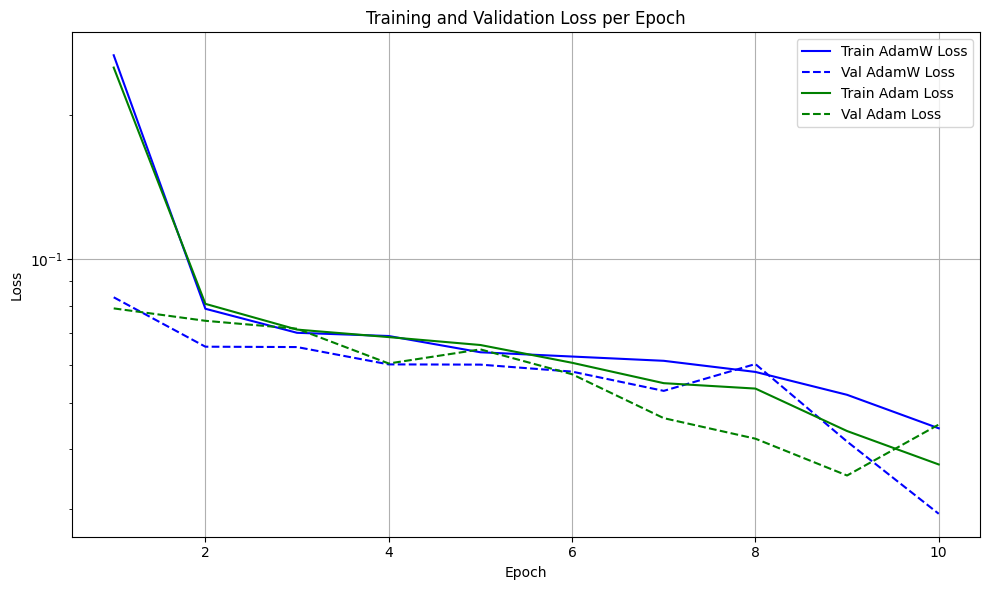

Final training loss: 0.037213279466794265, 0.04429485004647331
Final val loss: 0.04509976361784689, 0.02934233347240932
Best val loss (Adam): 0.035286272131784334, epoch#: 8
Best val loss (AdamW): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(LR_05_L1_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train AdamW Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val AdamW Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, LR_05_L1_loss, label='Train Adam Loss', color='green', linestyle='-')
# plt.plot(epochs, LR_05_L1_val_loss, label='Val Adam Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {LR_05_L1_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {LR_05_L1_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(LR_05_L1_val_loss)
# best_epoch = LR_05_L1_val_loss.index(best_val_loss)
# print(f'Best val loss (Adam): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (AdamW): {best_val_loss}, epoch#: {best_epoch}')

#### Droupout

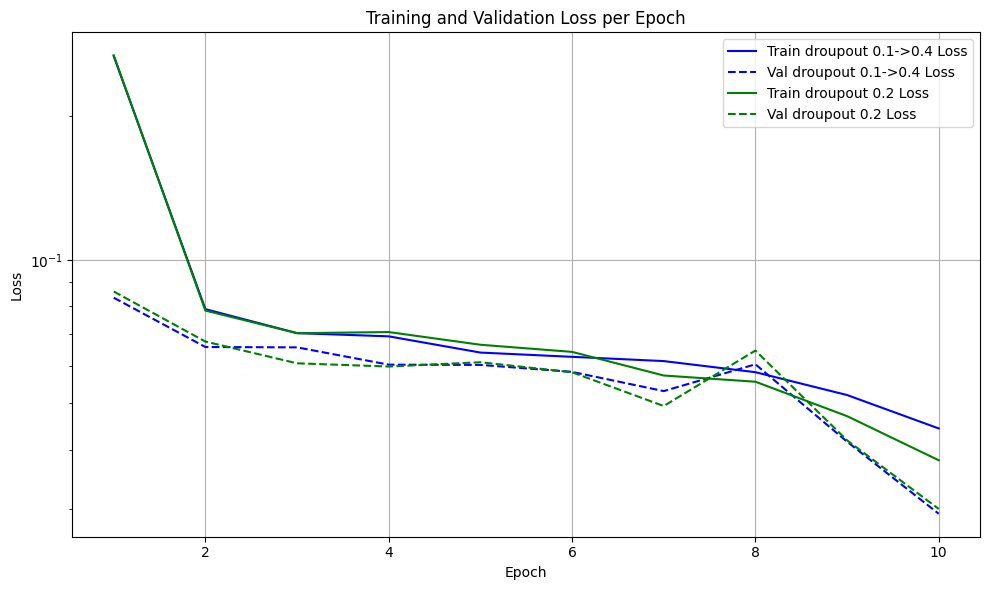

Final training loss: 0.03798806185916372, 0.04429485004647331
Final val loss: 0.030033955374372284, 0.02934233347240932
Best val loss (all 0.2): 0.030033955374372284, epoch#: 9
Best val loss (0.1->0.4): 0.02934233347240932, epoch#: 9


In [ ]:
# import matplotlib.pyplot as plt

# epochs = range(1, len(AdamW_loss) + 1)

# plt.figure(figsize=(10, 6))

# # 16 loss curves
# plt.plot(epochs, AdamW_loss, label='Train droupout 0.1->0.4 Loss', color='blue', linestyle='-')
# plt.plot(epochs, AdamW_val_loss, label='Val droupout 0.1->0.4 Loss', color='blue', linestyle='--')

# # # 64 loss curves
# plt.plot(epochs, droupout_all_02_loss, label='Train droupout 0.2 Loss', color='green', linestyle='-')
# plt.plot(epochs, droupout_all_02_val_loss, label='Val droupout 0.2 Loss', color='green', linestyle='--')

# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.yscale("log")
# plt.title('Training and Validation Loss per Epoch')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# print(f'Final training loss: {droupout_all_02_loss[-1]}, {AdamW_loss[-1]}')
# print(f'Final val loss: {droupout_all_02_val_loss[-1]}, {AdamW_val_loss[-1]}')

# best_val_loss = min(droupout_all_02_val_loss)
# best_epoch = droupout_all_02_val_loss.index(best_val_loss)
# print(f'Best val loss (all 0.2): {best_val_loss}, epoch#: {best_epoch}')

# best_val_loss = min(AdamW_val_loss)
# best_epoch = AdamW_val_loss.index(best_val_loss)
# print(f'Best val loss (0.1->0.4): {best_val_loss}, epoch#: {best_epoch}')

### Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")
# calcMSE(batch_16_L1_net)
# calcMSE(net_batch_32)
# calcMSE(net_LR_05)
# calcMSE(net_LR_00005)
# calcMSE(net_AdamW)
# calcMSE(net_batch_64)
# calcMSE(net_dropout_all_02)

## Part2-Transfer Learning

### General Train
* loss function: `SmoothL1Loss`
* Batch size: 32

In [ ]:
from models import Resnet18Grayscale, Resnet34Grayscale, DINOv2Keypoint
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()
            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}.pth"
        best_val_loss = float("inf")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

### ResNet

#### ResNet-Training
* ResNet18
* ResNet34
* Training Process: 5 for backbone + 10 for entire model

In [ ]:
def train_resnet(resnet, model_name):
  n_epochs_backbone_freeze = 5
  n_epochs_entire = 10
  # Freeze Backbone first
  for param in resnet.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
  loss, val_loss = train_net(resnet, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = resnet

  # Fine-tune
  for param in resnet.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.Adam(resnet.parameters(), lr=0.0001)
  fine_tune_loss, fine_tune_val_loss = train_net(resnet, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return fine_tune_loss, fine_tune_val_loss, resnet


resnet18 = Resnet18Grayscale()
resnet34 = Resnet34Grayscale()

resnet18_fine_tune_loss, resnet18_fine_tune_val_loss, resnet18 = train_resnet(resnet18, "resnet18_5_10")
resnet34_fine_tune_loss, resnet34_fine_tune_val_loss, resnet34 = train_resnet(resnet34, "resnet34_5_10")

#### ResNet-Evaluation-Viz

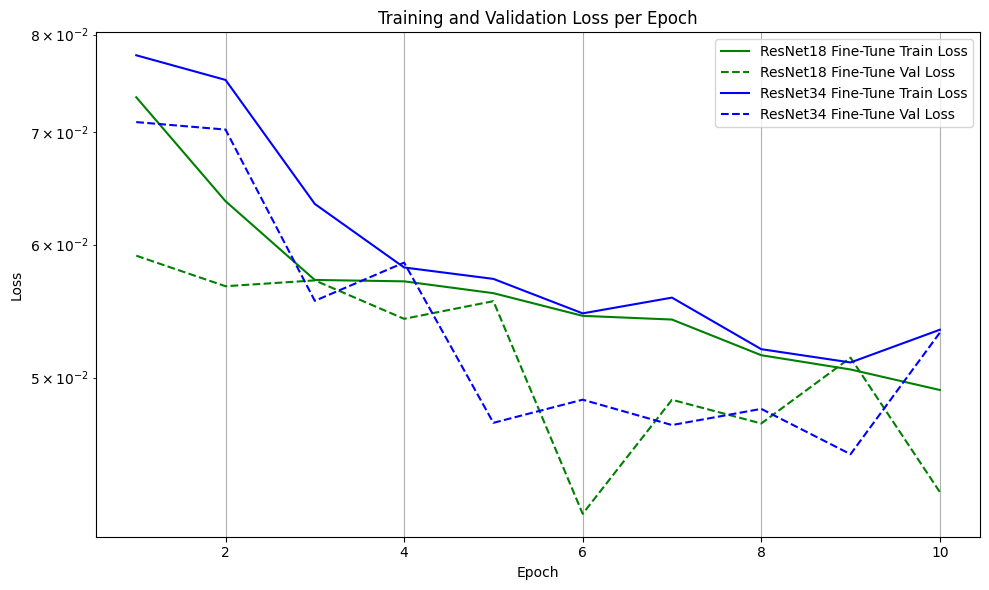

Final training loss: 0.05338959982986063, 0.04915943137400185
Final val loss: 0.05317371781113799, 0.04274732114237653
Best val loss: 0.04501998243019869, epoch#: 8
Best val loss: 0.04149022133407112, epoch#: 5


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(resnet18_fine_tune_loss) + 1)

plt.figure(figsize=(10, 6))


# plt.plot(epochs, resnet18_loss, label='ResNet18 Frozen Backbone Train Loss', color='blue', linestyle='-')
# plt.plot(epochs, resnet18_val_loss, label='ResNet18 Frozen Backbone Val Loss', color='blue', linestyle='--')


plt.plot(epochs, resnet18_fine_tune_loss, label='ResNet18 Fine-Tune Train Loss', color='green', linestyle='-')
plt.plot(epochs, resnet18_fine_tune_val_loss, label='ResNet18 Fine-Tune Val Loss', color='green', linestyle='--')
plt.plot(epochs, resnet34_fine_tune_loss, label='ResNet34 Fine-Tune Train Loss', color='blue', linestyle='-')
plt.plot(epochs, resnet34_fine_tune_val_loss, label='ResNet34 Fine-Tune Val Loss', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {resnet34_fine_tune_loss[-1]}, {resnet18_fine_tune_loss[-1]}')
print(f'Final val loss: {resnet34_fine_tune_val_loss[-1]}, {resnet18_fine_tune_val_loss[-1]}')

best_val_loss = min(resnet34_fine_tune_val_loss)
best_epoch = resnet34_fine_tune_val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

best_val_loss = min(resnet18_fine_tune_val_loss)
best_epoch = resnet18_fine_tune_val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

#### ResNet-Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")


calcMSE(resnet18)
calcMSE(resnet34)

### DINO

#### DINO-Training

In [ ]:
def train_dino(dino, model_name):
  n_epochs_backbone_freeze = 5
  n_epochs_entire = 10
  # Freeze Backbone first
  for param in dino.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.AdamW(filter(lambda p: p.requires_grad, dino.parameters()), lr=1e-3)
  loss, val_loss = train_net(dino, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = dino

  # Fine-tune
  for param in dino.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.AdamW(dino.parameters(), lr=1e-4)
  fine_tune_loss, fine_tune_val_loss = train_net(dino, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return fine_tune_loss, fine_tune_val_loss, dino


dino = DINOv2Keypoint()

train_loss, val_loss, dino = train_dino(dino, "dino")

epoch 0:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

training:  20%|██        | 1/5 [01:09<04:37, 69.29s/it]

Saved best model (Val Loss: 0.1015)
Epoch 1/5 | Train Loss: 0.1042 | Val Loss: 0.1015



training:  40%|████      | 2/5 [02:15<03:22, 67.52s/it]

Saved best model (Val Loss: 0.0844)
Epoch 2/5 | Train Loss: 0.0989 | Val Loss: 0.0844



training:  60%|██████    | 3/5 [03:21<02:13, 66.73s/it]

Saved best model (Val Loss: 0.0905)
Epoch 3/5 | Train Loss: 0.0928 | Val Loss: 0.0905



training:  80%|████████  | 4/5 [04:27<01:06, 66.38s/it]

Saved best model (Val Loss: 0.0858)
Epoch 4/5 | Train Loss: 0.0936 | Val Loss: 0.0858



training: 100%|██████████| 5/5 [05:33<00:00, 66.66s/it]


Saved best model (Val Loss: 0.0924)
Epoch 5/5 | Train Loss: 0.0967 | Val Loss: 0.0924


training:  10%|█         | 1/10 [02:44<24:42, 164.69s/it]

Saved best model (Val Loss: 0.0881)
Epoch 1/10 | Train Loss: 0.0958 | Val Loss: 0.0881



training:  20%|██        | 2/10 [05:30<22:01, 165.19s/it]

Saved best model (Val Loss: 0.0840)
Epoch 2/10 | Train Loss: 0.0972 | Val Loss: 0.0840



training:  30%|███       | 3/10 [08:15<19:15, 165.03s/it]

Saved best model (Val Loss: 0.0883)
Epoch 3/10 | Train Loss: 0.0965 | Val Loss: 0.0883



training:  40%|████      | 4/10 [11:00<16:30, 165.14s/it]

Saved best model (Val Loss: 0.0844)
Epoch 4/10 | Train Loss: 0.0939 | Val Loss: 0.0844



training:  50%|█████     | 5/10 [13:45<13:44, 164.98s/it]

Saved best model (Val Loss: 0.0857)
Epoch 5/10 | Train Loss: 0.0912 | Val Loss: 0.0857



training:  60%|██████    | 6/10 [16:30<11:00, 165.12s/it]

Saved best model (Val Loss: 0.0862)
Epoch 6/10 | Train Loss: 0.0920 | Val Loss: 0.0862



training:  70%|███████   | 7/10 [19:15<08:15, 165.10s/it]

Saved best model (Val Loss: 0.0824)
Epoch 7/10 | Train Loss: 0.0901 | Val Loss: 0.0824



training:  80%|████████  | 8/10 [22:00<05:30, 165.01s/it]

Saved best model (Val Loss: 0.0904)
Epoch 8/10 | Train Loss: 0.0949 | Val Loss: 0.0904



training:  90%|█████████ | 9/10 [24:45<02:45, 165.21s/it]

Saved best model (Val Loss: 0.0860)
Epoch 9/10 | Train Loss: 0.0922 | Val Loss: 0.0860



training: 100%|██████████| 10/10 [27:31<00:00, 165.12s/it]

Saved best model (Val Loss: 0.0796)
Epoch 10/10 | Train Loss: 0.0919 | Val Loss: 0.0796


#### DiNO-Evaluation-Viz

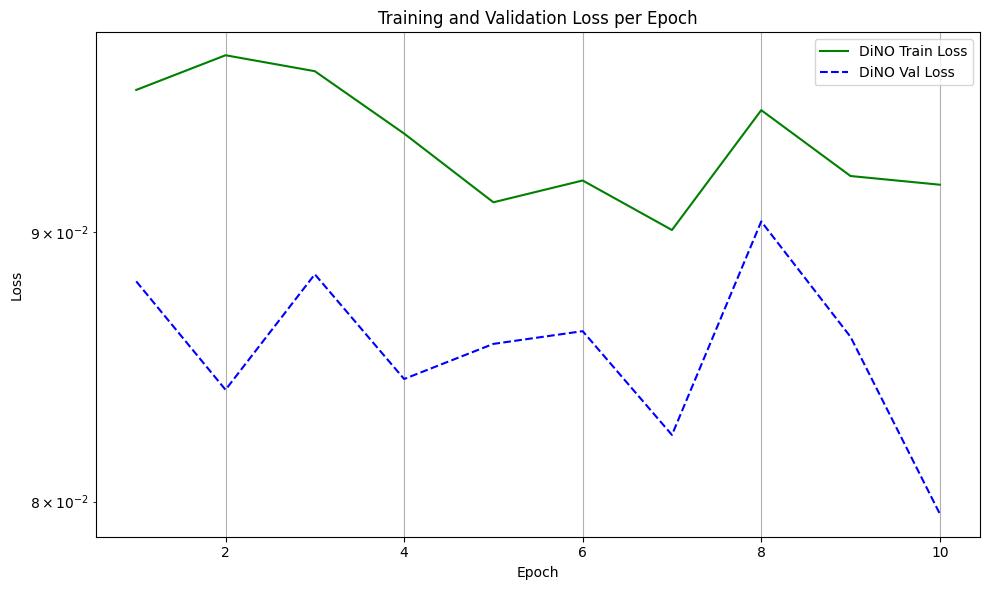

Final training loss: 0.09186892199419137
Final val loss: 0.07957467078488205
Best val loss: 0.07957467078488205, epoch#: 9


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))


plt.plot(epochs, train_loss, label='DiNO Train Loss', color='green', linestyle='-')
plt.plot(epochs, val_loss, label='DiNO Val Loss', color='blue', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale("log")
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f'Final training loss: {train_loss[-1]}')
print(f'Final val loss: {val_loss[-1]}')

best_val_loss = min(val_loss)
best_epoch = val_loss.index(best_val_loss)
print(f'Best val loss: {best_val_loss}, epoch#: {best_epoch}')

#### DINO-Evaluation-Metric

In [ ]:
from torch.nn import MSELoss

def calcMSE(net):
  net.eval()
  net.cuda()
  mse = MSELoss()
  total_mse = 0.0
  with torch.no_grad():
      for data in test_loader:
          images = data['image'].cuda()
          key_pts = data['keypoints'].view(-1, 136).cuda()
          outputs = net(images)
          total_mse += mse(outputs, key_pts).item()

  mean_mse = total_mse / len(test_loader)
  print(f"Test Mean Squared Error: {mean_mse:.4f}")

dino_pred = DINOv2Keypoint()
dino_pred.load_state_dict(torch.load("./models/dino.pth"))
calcMSE(dino_pred)

Test Mean Squared Error: 0.1720


# Train your model

# Visualize the model predictions

torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


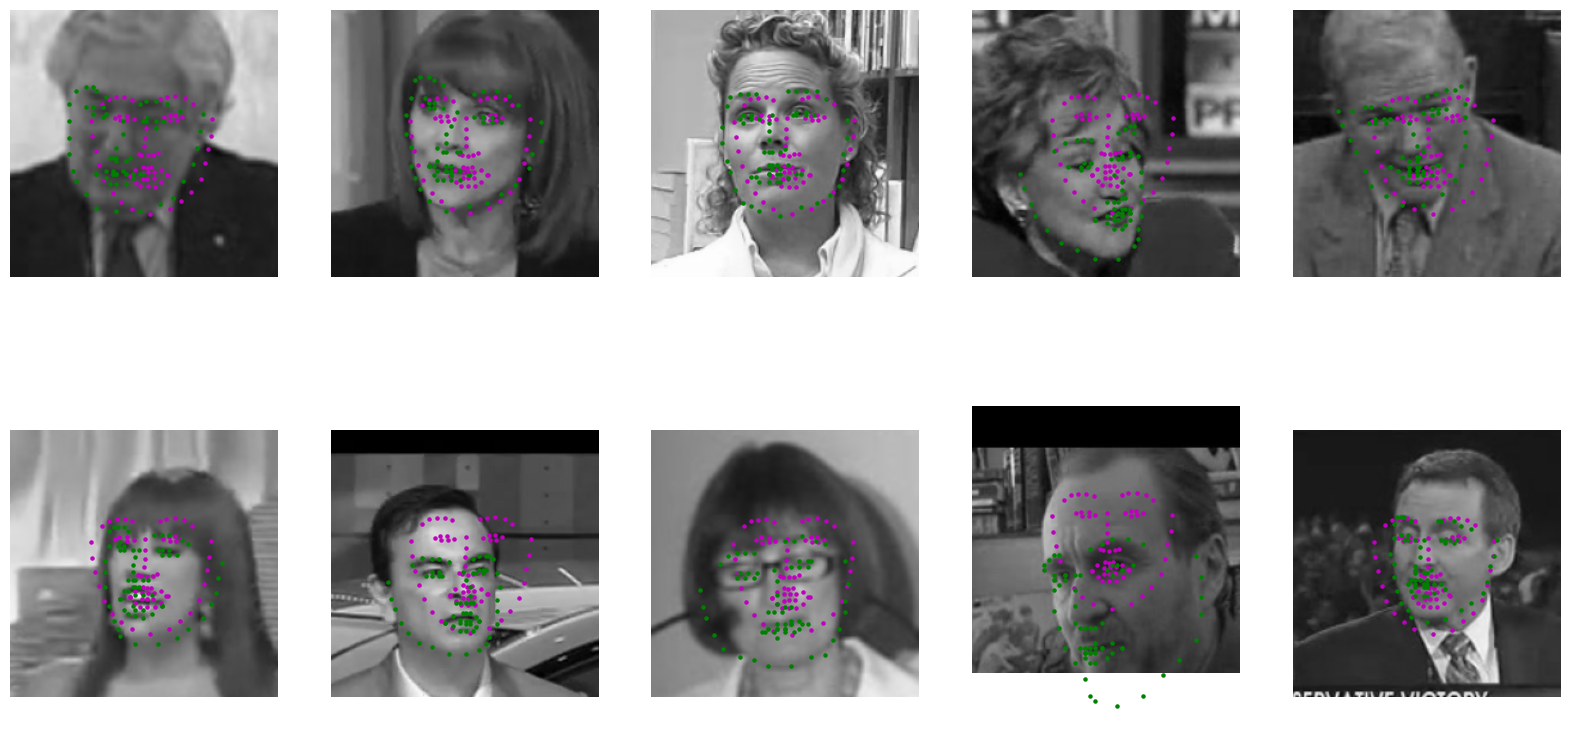

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """
    Show image with predicted keypoints and optionally ground truth keypoints
    """
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image]*3, axis=2)

    plt.imshow(image*255, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')

    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


# test the model on a batch of test images
def net_sample_output(model, test_loader):

    # iterate through the test dataset
    for i, sample in enumerate(test_loader):

        # getting sample data: images and ground truth keypoints
        images = sample["image"]
        key_pts = sample["keypoints"]

        # converting images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forwarding pass to get net output
        output_pts = model(images)

        # reshaping to batch_size x 68 x 2 pts # (136*1) => (68*2)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return (
                images,
                output_pts,
                key_pts,
            )  # images, predicted key points, real keypoints

# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform the image data
        image = test_images[i].data  # get the image from its Variable wrapper
        image = image.numpy()  # convert to numpy array from a Tensor
        image = np.transpose(
            image, (1, 2, 0)
        )  # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()

        # undo normalization of keypoints
        predicted_key_pts = predicted_key_pts * 50.0 + 100

        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]
            ground_truth_pts = ground_truth_pts * 50.0 + 100

        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)

        plt.axis("off")

    plt.show()



net = dino_pred
# get a sample of test data again
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
test_images, test_outputs, gt_pts = net_sample_output(net.cpu(), test_loader)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

# visualize the test output
visualize_output(test_images, test_outputs, gt_pts)

# Training UNet with Heatmaps

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


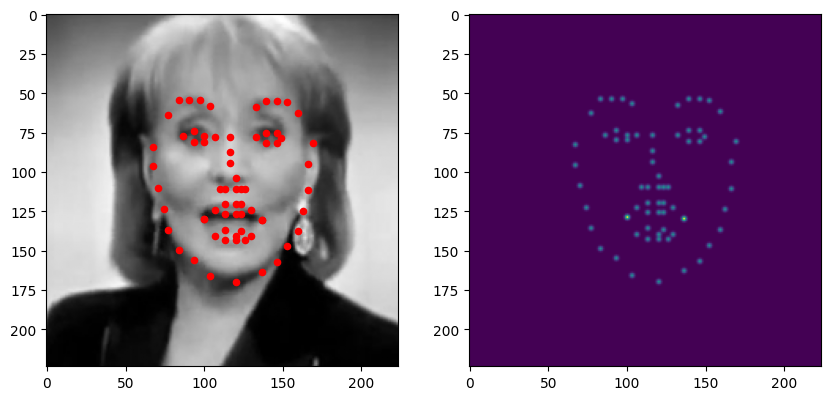

In [ ]:
# importing the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.optim as optim
from tqdm import tqdm


# the transforms we defined in Notebook 1 are in the helper file `custom_transforms.py`
from custom_transforms import (
    Rescale,
    RandomCrop,
    NormalizeOriginal,
    ToTensor,
)

# the dataset we created in Notebook 1
from facial_keypoints_dataset import FacialKeypointsHeatmapDataset



# defining the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose(
    [Rescale(250), RandomCrop(224), NormalizeOriginal(), ToTensor()]
)

training_keypoints_csv_path = os.path.join("data", "training_frames_keypoints.csv")
training_data_dir = os.path.join("data", "training")
test_keypoints_csv_path = os.path.join("data", "test_frames_keypoints.csv")
test_data_dir = os.path.join("data", "test")


# create the transformed dataset
transformed_dataset = FacialKeypointsHeatmapDataset(
    csv_file=training_keypoints_csv_path,
    root_dir=training_data_dir,
    transform=data_transform,
    output_size=224
)
# load training data in batches
batch_size = 16
train_loader = DataLoader(
    transformed_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

# creating the test dataset
test_dataset = FacialKeypointsHeatmapDataset(
    csv_file=test_keypoints_csv_path,
    root_dir=test_data_dir,
    transform=data_transform,
    output_size=224
)
# loading test data in batches
batch_size = 16
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

for i, data in enumerate(test_loader):
    sample = data
    image = sample['image'][0]
    keypoints = sample['keypoints'][0]
    # plot the image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0), cmap='gray')
    plt.scatter(keypoints[:, 0]*50+100, keypoints[:, 1]*50+100, c='r', s=20)
    # show the heatmaps
    plt.subplot(1, 2, 2)
    heatmaps = sample['heatmaps'][0].sum(dim=0, keepdim=True)
    plt.imshow(heatmaps.numpy().transpose(1, 2, 0))
    plt.show()
    break


In [ ]:
import numpy as np
import cv2

def generate_heatmap(keypoints, heatmap_size=64, image_size=224, sigma=1.5):
    """Generate K Gaussian heatmaps for 68 keypoints"""
    K = keypoints.shape[0]
    heatmaps = np.zeros((K, heatmap_size, heatmap_size), dtype=np.float32)

    for i, (x, y) in enumerate(keypoints):
        if x < 0 or y < 0:
            continue
        x = int(x / image_size * heatmap_size)
        y = int(y / image_size * heatmap_size)
        heatmap = np.zeros((heatmap_size, heatmap_size), dtype=np.float32)
        cv2.circle(heatmap, (x, y), 0, 1, -1)
        heatmap = cv2.GaussianBlur(heatmap, (0, 0), sigma)
        heatmap /= np.max(heatmap) if np.max(heatmap) > 0 else 1
        heatmaps[i] = heatmap
    return heatmaps

In [ ]:
# TODO: training code for UNet with heatmaps
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from models import UNetKeypoint
from tqdm import tqdm

# Training loop for U-Net
def train_unet(model, train_loader, val_loader, n_epochs=20, device="cuda", save_path="./models/unet_best.pth"):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for batch in train_loader:
            images = batch["image"].to(device)  # [B, 1, 224, 224]
            heatmaps = batch["heatmaps"].to(device)  # [B, 68, 64, 64]

            optimizer.zero_grad()
            outputs = model(images)  # [B, 68, 64, 64]
            loss = criterion(outputs, heatmaps)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        val_loss = validate_unet(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
            print("Best model saved.")
        return train_losses, val_losses

# Validation loop
def validate_unet(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            heatmaps = batch["heatmaps"].to(device)
            outputs = model(images)
            loss = criterion(outputs, heatmaps)
            val_loss += loss.item()
    model.train()
    return val_loss / len(val_loader)
model = UNetKeypoint()
train_losses, val_losses = train_unet(model, train_loader, test_loader, n_epochs=30)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# TODO: visualize your predictions
def net_sample_output(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, sample in enumerate(test_loader):
            images = sample["image"].float()
            key_pts = sample["keypoints"]

            outputs = model(images)
            outputs = outputs.view(outputs.size(0), 68, 2)

            return images, outputs, key_pts

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):
    plt.figure(figsize=(20, 10))
    for i in range(batch_size):
        ax = plt.subplot(batch_size // 5, 5, i + 1)

        # un-transform image
        image = test_images[i].cpu().detach().numpy()
        image = np.transpose(image, (1, 2, 0))
        image = image * 0.5 + 0.5  # assuming normalized to [-1,1] originally
        image = np.clip(image, 0, 1)

        # predicted keypoints
        predicted_key_pts = test_outputs[i].cpu().detach().numpy()
        predicted_key_pts = predicted_key_pts * 50.0 + 100
        predicted_key_pts = np.clip(predicted_key_pts, 0, 224)  # clip to image size

        # ground truth
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i].cpu().detach().numpy()
            ground_truth_pts = ground_truth_pts * 50.0 + 100
            ground_truth_pts = np.clip(ground_truth_pts, 0, 224)

        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
        plt.axis("off")

    plt.show()

net = dino_pred  # your trained DINOv2 model
net.cpu()        # move to CPU for inference/visualization
net.eval()       # set to eval mode

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

print(test_images.shape)     # [10, 1, 224, 224]
print(test_outputs.shape)    # [10, 68, 2]
print(gt_pts.shape)          # [10, 68, 2]

visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
# Moved




from models import SimpleNet, Resnet18Grayscale, Resnet34Grayscale
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}.pth"
        best_val_loss = float("inf")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


# ===================================
# Part 1 Net
# Loss Function
# net_SmoothL1 = SimpleNet()
# net_MSELoss = SimpleNet()

# net_batch_64 = SimpleNet()
# net_LR_05 = SimpleNet()
# net_LR_00005 = SimpleNet()

# net_AdamW = SimpleNet()
# net_dropout_all_02 = SimpleNet()


# ========== HYPERPARAMETERS ==========
# n_epochs = 10
# optimizer_smoothL1 = optim.Adam(net_LR_00005.parameters(), lr=0.0005)
# optimizer_MSE = optim.Adam(net_MSELoss.parameters(), lr=0.001)
# optimizer = optim.AdamW(net_dropout_all_02.parameters(), lr=0.0005)


# ========== TRAIN MODELS ==========
# Loss Function
# SmoothL1_losses, val_SmoothL1_losses = train_net(net_SmoothL1, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)
# MSE_losses, val_MSE_losses = train_net(net_MSELoss, n_epochs, nn.MSELoss(), optimizer_MSE, test_loader)

# Batch Size
# LR_05_L1_loss, LR_05_L1_val_loss = train_net(net_LR_00005, n_epochs, nn.SmoothL1Loss(), optimizer_smoothL1, test_loader)

# AdamW_loss, AdamW_val_loss = train_net(net_AdamW, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)

# droupout_all_02_loss, droupout_all_02_val_loss = train_net(net_dropout_all_02, n_epochs, nn.SmoothL1Loss(), optimizer, test_loader)



# =================================Resnet
def train_resnet(resnet, model_name):
  n_epochs_backbone_freeze = 5
  n_epochs_entire = 10
  # Freeze Backbone first
  for param in resnet.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)
  loss, val_loss = train_net(resnet, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = resnet

  # Fine-tune
  for param in resnet.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.Adam(resnet.parameters(), lr=0.0001)
  fine_tune_loss, fine_tune_val_loss = train_net(resnet, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return loss, val_loss, fine_tune_loss, fine_tune_val_loss, temp_net, resnet


resnet18 = Resnet18Grayscale()
resnet34 = Resnet34Grayscale()

resnet18_loss, resnet18_val_loss, \
resnet18_fine_tune_loss, resnet18_fine_tune_val_loss, \
temp_net18, resnet18 = train_resnet(resnet18, "resnet18_5_10")


resnet34_loss, resnet34_val_loss, \
resnet34_fine_tune_loss, resnet34_fine_tune_val_loss, \
temp_net34, resnet34 = train_resnet(resnet34, "resnet34_5_10")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weig

Saved best model (Val Loss: 0.1101)
Epoch 1/5 | Train Loss: 0.1305 | Val Loss: 0.1101



training:  40%|████      | 2/5 [00:32<00:48, 16.14s/it]

Saved best model (Val Loss: 0.0697)
Epoch 2/5 | Train Loss: 0.0853 | Val Loss: 0.0697



training:  60%|██████    | 3/5 [00:47<00:31, 15.96s/it]

Saved best model (Val Loss: 0.0632)
Epoch 3/5 | Train Loss: 0.0682 | Val Loss: 0.0632



training:  80%|████████  | 4/5 [01:03<00:15, 15.69s/it]

Saved best model (Val Loss: 0.0559)
Epoch 4/5 | Train Loss: 0.0622 | Val Loss: 0.0559



training: 100%|██████████| 5/5 [01:18<00:00, 15.72s/it]


Saved best model (Val Loss: 0.0626)
Epoch 5/5 | Train Loss: 0.0569 | Val Loss: 0.0626


training:  10%|█         | 1/10 [00:17<02:36, 17.34s/it]

Saved best model (Val Loss: 0.0591)
Epoch 1/10 | Train Loss: 0.0734 | Val Loss: 0.0591



training:  20%|██        | 2/10 [00:33<02:13, 16.64s/it]

Saved best model (Val Loss: 0.0567)
Epoch 2/10 | Train Loss: 0.0637 | Val Loss: 0.0567



training:  30%|███       | 3/10 [00:49<01:53, 16.28s/it]

Saved best model (Val Loss: 0.0571)
Epoch 3/10 | Train Loss: 0.0572 | Val Loss: 0.0571



training:  40%|████      | 4/10 [01:05<01:37, 16.18s/it]

Saved best model (Val Loss: 0.0542)
Epoch 4/10 | Train Loss: 0.0570 | Val Loss: 0.0542



training:  50%|█████     | 5/10 [01:21<01:21, 16.27s/it]

Saved best model (Val Loss: 0.0555)
Epoch 5/10 | Train Loss: 0.0561 | Val Loss: 0.0555



training:  60%|██████    | 6/10 [01:38<01:05, 16.25s/it]

Saved best model (Val Loss: 0.0415)
Epoch 6/10 | Train Loss: 0.0544 | Val Loss: 0.0415



training:  70%|███████   | 7/10 [01:54<00:48, 16.20s/it]

Saved best model (Val Loss: 0.0485)
Epoch 7/10 | Train Loss: 0.0541 | Val Loss: 0.0485



training:  80%|████████  | 8/10 [02:11<00:32, 16.45s/it]

Saved best model (Val Loss: 0.0470)
Epoch 8/10 | Train Loss: 0.0516 | Val Loss: 0.0470



training:  90%|█████████ | 9/10 [02:29<00:17, 17.13s/it]

Saved best model (Val Loss: 0.0514)
Epoch 9/10 | Train Loss: 0.0506 | Val Loss: 0.0514



training: 100%|██████████| 10/10 [02:47<00:00, 16.74s/it]


Saved best model (Val Loss: 0.0427)
Epoch 10/10 | Train Loss: 0.0492 | Val Loss: 0.0427


training:  20%|██        | 1/5 [00:18<01:13, 18.34s/it]

Saved best model (Val Loss: 0.1008)
Epoch 1/5 | Train Loss: 0.1353 | Val Loss: 0.1008



training:  40%|████      | 2/5 [00:36<00:53, 17.98s/it]

Saved best model (Val Loss: 0.0668)
Epoch 2/5 | Train Loss: 0.0863 | Val Loss: 0.0668



training:  60%|██████    | 3/5 [00:53<00:35, 17.61s/it]

Saved best model (Val Loss: 0.0589)
Epoch 3/5 | Train Loss: 0.0691 | Val Loss: 0.0589



training:  80%|████████  | 4/5 [01:11<00:17, 17.82s/it]

Saved best model (Val Loss: 0.0614)
Epoch 4/5 | Train Loss: 0.0647 | Val Loss: 0.0614



training: 100%|██████████| 5/5 [01:28<00:00, 17.75s/it]


Saved best model (Val Loss: 0.0552)
Epoch 5/5 | Train Loss: 0.0564 | Val Loss: 0.0552


training:  10%|█         | 1/10 [00:22<03:21, 22.40s/it]

Saved best model (Val Loss: 0.0710)
Epoch 1/10 | Train Loss: 0.0778 | Val Loss: 0.0710



training:  20%|██        | 2/10 [00:43<02:53, 21.64s/it]

Saved best model (Val Loss: 0.0702)
Epoch 2/10 | Train Loss: 0.0752 | Val Loss: 0.0702



training:  30%|███       | 3/10 [01:04<02:30, 21.49s/it]

Saved best model (Val Loss: 0.0555)
Epoch 3/10 | Train Loss: 0.0634 | Val Loss: 0.0555



training:  40%|████      | 4/10 [01:25<02:08, 21.33s/it]

Saved best model (Val Loss: 0.0585)
Epoch 4/10 | Train Loss: 0.0581 | Val Loss: 0.0585



training:  50%|█████     | 5/10 [01:47<01:47, 21.45s/it]

Saved best model (Val Loss: 0.0470)
Epoch 5/10 | Train Loss: 0.0572 | Val Loss: 0.0470



training:  60%|██████    | 6/10 [02:09<01:26, 21.56s/it]

Saved best model (Val Loss: 0.0485)
Epoch 6/10 | Train Loss: 0.0546 | Val Loss: 0.0485



training:  70%|███████   | 7/10 [02:30<01:04, 21.39s/it]

Saved best model (Val Loss: 0.0469)
Epoch 7/10 | Train Loss: 0.0558 | Val Loss: 0.0469



training:  80%|████████  | 8/10 [02:52<00:42, 21.46s/it]

Saved best model (Val Loss: 0.0479)
Epoch 8/10 | Train Loss: 0.0520 | Val Loss: 0.0479



training:  90%|█████████ | 9/10 [03:14<00:21, 21.71s/it]

Saved best model (Val Loss: 0.0450)
Epoch 9/10 | Train Loss: 0.0510 | Val Loss: 0.0450



training: 100%|██████████| 10/10 [03:35<00:00, 21.53s/it]

Saved best model (Val Loss: 0.0532)
Epoch 10/10 | Train Loss: 0.0534 | Val Loss: 0.0532


In [ ]:
from models import SimpleNet, Resnet18Grayscale, Resnet34Grayscale, DINOv2Keypoint
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# ========== VALIDATION FUNCTION ==========
def validate(net, val_loader, criterion):
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images = data["image"].cuda()
            key_pts = data["keypoints"].view(-1, 136).cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            outputs = net(images)
            loss = criterion(outputs, key_pts)
            val_loss += loss.item()

    return val_loss / len(val_loader)


# ========== TRAINING FUNCTION ==========
def train_net(net, n_epochs, criterion, optimizer, val_loader, model_name):
    train_losses = []
    val_losses = []

    net.train()
    net.cuda()

    for epoch in tqdm(range(n_epochs), desc="training"):
        running_loss = 0.0

        for data in tqdm(train_loader, desc=f"epoch {epoch}"):
            images = data["image"].cuda()
            key_pts = data["keypoints"].cuda()

            if isinstance(criterion, nn.MSELoss):
                images = images.type(torch.float32)
                key_pts = key_pts.type(torch.float32)

            key_pts = key_pts.view(key_pts.size(0), -1)

            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, key_pts)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Compute epoch-level losses
        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        epoch_val_loss = validate(net, val_loader, criterion)
        val_losses.append(epoch_val_loss)

        os.makedirs("./models", exist_ok=True)

        save_path = f"./models/{model_name}.pth"
        best_val_loss = float("inf")
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(net.state_dict(), save_path)
            print(f"Saved best model (Val Loss: {best_val_loss:.4f})")

        print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses

def train_dino(dino, model_name):
  n_epochs_backbone_freeze = 5
  n_epochs_entire = 10
  # Freeze Backbone first
  for param in dino.backbone.parameters():
      param.requires_grad = False

  optimizer = optim.Adam(filter(lambda p: p.requires_grad, dino.parameters()), lr=1e-4)
  loss, val_loss = train_net(dino, n_epochs_backbone_freeze, nn.SmoothL1Loss(), optimizer, test_loader, model_name)

  temp_net = dino

  # Fine-tune
  for param in dino.backbone.parameters():
      param.requires_grad = True

  optimizer_fine_tune = optim.Adam(dino.parameters(), lr=1e-5)
  fine_tune_loss, fine_tune_val_loss = train_net(dino, n_epochs_entire, nn.SmoothL1Loss(), optimizer, test_loader, model_name)
  return fine_tune_loss, fine_tune_val_loss, dino


dino = DINOv2Keypoint()

train_loss, val_loss, dino = train_dino(dino, "dino")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/436 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

epoch 0:   0%|          | 0/109 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(

training:  20%|██        | 1/5 [01:08<04:32, 68.02s/it]

Saved best model (Val Loss: 0.0814)
Epoch 1/5 | Train Loss: 0.1225 | Val Loss: 0.0814



training:  40%|████      | 2/5 [02:13<03:19, 66.65s/it]

Saved best model (Val Loss: 0.0835)
Epoch 2/5 | Train Loss: 0.0887 | Val Loss: 0.0835



training:  60%|██████    | 3/5 [03:19<02:12, 66.21s/it]

Saved best model (Val Loss: 0.0898)
Epoch 3/5 | Train Loss: 0.0921 | Val Loss: 0.0898



training:  80%|████████  | 4/5 [04:25<01:06, 66.15s/it]

Saved best model (Val Loss: 0.0806)
Epoch 4/5 | Train Loss: 0.0889 | Val Loss: 0.0806



training: 100%|██████████| 5/5 [05:31<00:00, 66.28s/it]


Saved best model (Val Loss: 0.0847)
Epoch 5/5 | Train Loss: 0.0901 | Val Loss: 0.0847


training:  10%|█         | 1/10 [02:44<24:41, 164.59s/it]

Saved best model (Val Loss: 0.0855)
Epoch 1/10 | Train Loss: 0.0909 | Val Loss: 0.0855



training:  20%|██        | 2/10 [05:29<21:57, 164.72s/it]

Saved best model (Val Loss: 0.0870)
Epoch 2/10 | Train Loss: 0.0898 | Val Loss: 0.0870



training:  30%|███       | 3/10 [08:14<19:13, 164.73s/it]

Saved best model (Val Loss: 0.0875)
Epoch 3/10 | Train Loss: 0.0936 | Val Loss: 0.0875



training:  40%|████      | 4/10 [10:59<16:29, 164.95s/it]

Saved best model (Val Loss: 0.0835)
Epoch 4/10 | Train Loss: 0.0910 | Val Loss: 0.0835



training:  50%|█████     | 5/10 [13:46<13:48, 165.72s/it]

Saved best model (Val Loss: 0.0833)
Epoch 5/10 | Train Loss: 0.0931 | Val Loss: 0.0833



training:  60%|██████    | 6/10 [16:31<11:02, 165.54s/it]

Saved best model (Val Loss: 0.0866)
Epoch 6/10 | Train Loss: 0.0896 | Val Loss: 0.0866



training:  70%|███████   | 7/10 [19:17<08:16, 165.47s/it]

Saved best model (Val Loss: 0.0777)
Epoch 7/10 | Train Loss: 0.0919 | Val Loss: 0.0777



training:  80%|████████  | 8/10 [22:01<05:30, 165.27s/it]

Saved best model (Val Loss: 0.0833)
Epoch 8/10 | Train Loss: 0.0931 | Val Loss: 0.0833



training:  90%|█████████ | 9/10 [24:46<02:45, 165.13s/it]

Saved best model (Val Loss: 0.0827)
Epoch 9/10 | Train Loss: 0.0896 | Val Loss: 0.0827



training: 100%|██████████| 10/10 [27:31<00:00, 165.14s/it]

Saved best model (Val Loss: 0.0801)
Epoch 10/10 | Train Loss: 0.0930 | Val Loss: 0.0801
